Приведем заголовки файла с генами к названиям csv файла с пациентами

In [1]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('gene_expression_TCGA_PRAD.csv')

# Преобразование заголовков (обрезаем до 12 символов)
new_columns = [col[:12] for col in df.columns]
df.columns = new_columns

# Сохранение в новый файл (или перезапись существующего)
df.to_csv('gene_expression_TCGA_PRAD_short.csv', index=False)

Нормализуем данные

In [ ]:
# Загрузка данных
df = pd.read_csv('gene_expression_TCGA_PRAD_short.csv', index_col=0)  # Гены в строках

# Нормализация по Z-баллам (по строкам)
normalized_df = df.apply(
    lambda row: round((row - row.mean()) / row.std(),2),
    axis=1
)

# Проверка результата
print(normalized_df.head())

# Сохранение
normalized_df.to_csv('gene_expression_TCGA_PRAD_normalized_zscore.csv')

                    TCGA-KK-A7AU  TCGA-VN-A88M  TCGA-KC-A4BR  TCGA-KC-A7FA  \
Unnamed: 0                                                                   
ENSG00000000003.15         -0.07         -0.44         -1.12         -0.70   
ENSG00000000005.6          -0.24         -0.15          1.01          0.75   
ENSG00000000419.13          0.38         -0.77         -0.24         -0.34   
ENSG00000000457.14          0.63         -0.49         -0.46         -0.64   
ENSG00000000460.17          0.15         -1.16         -0.30         -0.61   

                    TCGA-HC-A6HY  TCGA-QU-A6IN  TCGA-KK-A6E0  TCGA-XK-AAJA  \
Unnamed: 0                                                                   
ENSG00000000003.15          0.58         -0.73         -0.46          1.88   
ENSG00000000005.6           0.01         -0.21         -0.23         -0.15   
ENSG00000000419.13          0.13         -1.59          0.12          0.22   
ENSG00000000457.14         -0.36         -0.57         -1.06   

In [ ]:
import pandas as pd
import numpy as np

# 1. Загрузка данных (гены в строках, пациенты в столбцах)
df = pd.read_csv('gene_expression_TCGA_PRAD_normalized_zscore.csv', index_col=0)

# 2. Расчет среднего абсолютного отклонения для каждого гена
gene_maz = df.apply(lambda row: np.mean(np.abs(row)), axis=1)  # MAZ = Mean Absolute Z-score

# 3. Удаление генов с NaN-значениями (если такие есть)
gene_maz_cleaned = gene_maz.dropna()

# 4. Сортировка генов по MAZ (от самых стабильных до самых изменчивых)
gene_ranking_maz = gene_maz_cleaned.sort_values()

# 5. Сохранение результатов
gene_ranking_maz.to_csv('gene_mean_absolute_zscore_ranking.csv', header=['MAZ'])

# 6. Вывод топ-25 самых стабильных и изменчивых генов
print("Топ-25 стабильных генов (низкий MAZ):\n", gene_ranking_maz.head(25))
print("\nТоп-25 изменчивых генов (высокий MAZ):\n", gene_ranking_maz.tail(25))

print(f"\nУдалено генов с NaN: {len(gene_maz) - len(gene_maz_cleaned)}")

Топ-10 стабильных генов (низкий MAZ):
 Unnamed: 0
ENSG00000231510.1     0.081137
ENSG00000142163.8     0.081408
ENSG00000229967.1     0.081859
ENSG00000185873.8     0.081877
ENSG00000240606.3     0.082004
ENSG00000227809.2     0.082022
ENSG00000164299.7     0.082058
ENSG00000258770.1     0.082076
ENSG00000094661.3     0.082148
ENSG00000147381.11    0.082166
ENSG00000249861.4     0.082184
ENSG00000165606.9     0.082202
ENSG00000268153.5     0.082238
ENSG00000283346.1     0.082329
ENSG00000263918.1     0.082329
ENSG00000206948.1     0.082329
ENSG00000264115.1     0.082329
ENSG00000207013.1     0.082329
ENSG00000199698.1     0.082329
ENSG00000276039.1     0.082329
ENSG00000252219.2     0.082329
ENSG00000252252.1     0.082329
ENSG00000234986.1     0.082329
ENSG00000252437.1     0.082329
ENSG00000271546.1     0.082329
dtype: float64

Топ-10 изменчивых генов (высокий MAZ):
 Unnamed: 0
ENSG00000134717.18    0.814495
ENSG00000099968.18    0.814964
ENSG00000271314.1     0.815596
ENSG00000125841

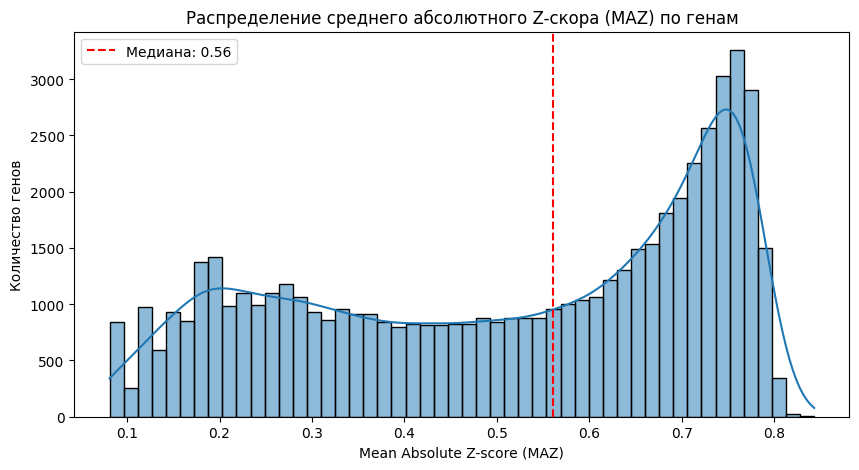

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(gene_maz, bins=50, kde=True)
plt.axvline(gene_maz.median(), color='red', linestyle='--', label=f'Медиана: {gene_maz.median():.2f}')
plt.title('Распределение среднего абсолютного Z-скора (MAZ) по генам')
plt.xlabel('Mean Absolute Z-score (MAZ)')
plt.ylabel('Количество генов')
plt.legend()
plt.savefig('gene_maz_distribution.png', dpi=120)
plt.show()

При первом приближении видно, что генов, которые в равной степени выражены у пациентов < 5000, если искать зависимость между конкретным геном (не парой) и заболеванием, возможно взять наиболее равномерно выраженные за основу

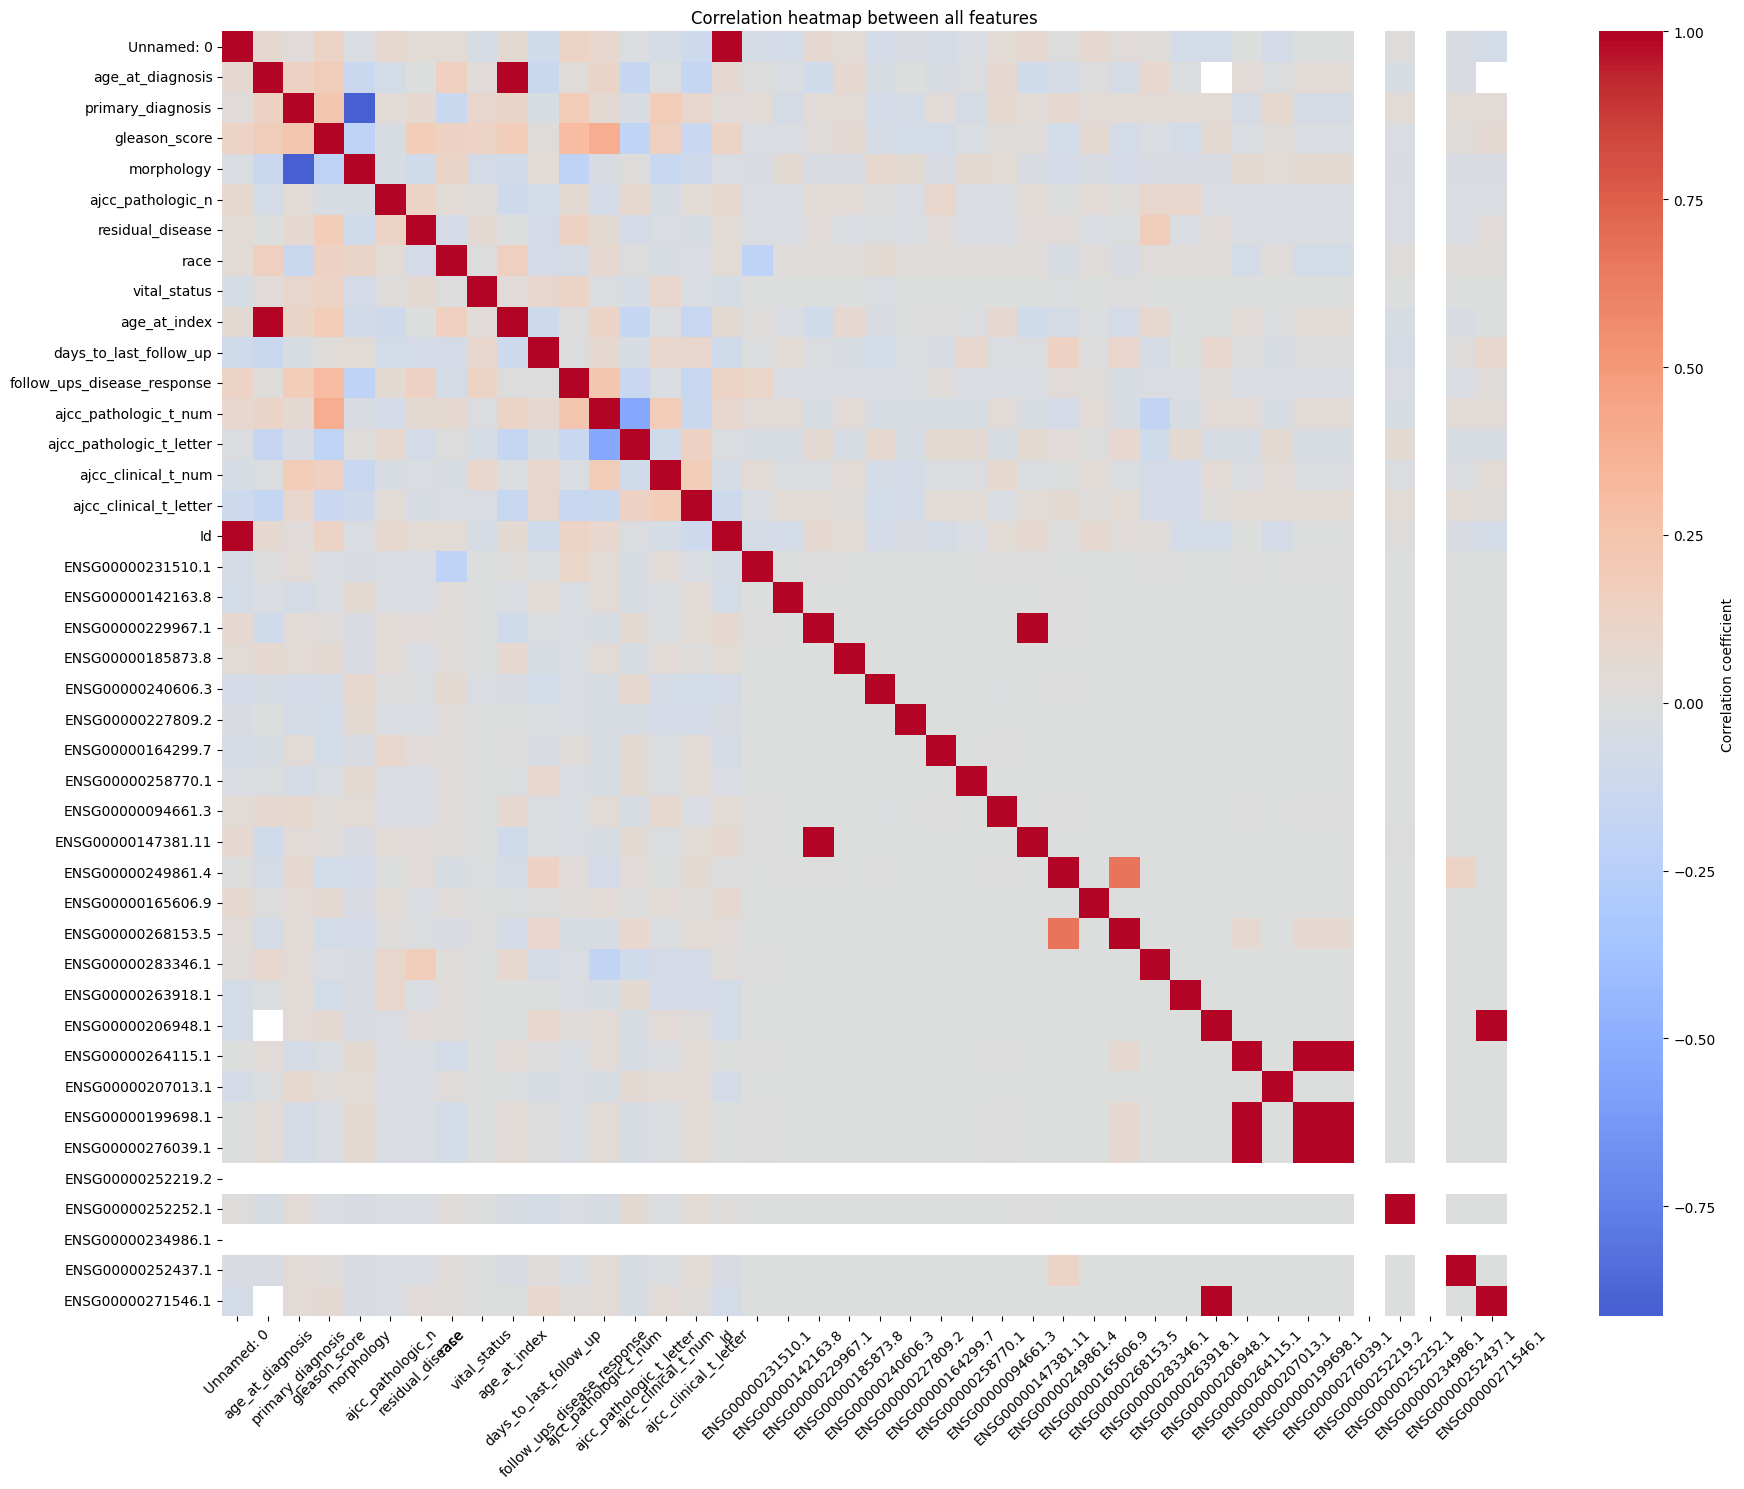

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загружаем топ-25 генов
top_genes = pd.read_csv('gene_mean_absolute_zscore_ranking.csv')
top_genes.columns = ['gene_id', 'MAZ']  
top_25_genes = top_genes.head(25)['gene_id']

# 2. Загружаем оригинальные данные экспрессии
gene_expr = pd.read_csv('gene_expression_TCGA_PRAD_short.csv', index_col=0)

# Выбираем только топ-25 генов
top_25_expr = gene_expr.loc[top_25_genes]

# Транспонируем, чтобы пациенты были в строках
top_25_expr_transposed = top_25_expr.T.reset_index()
top_25_expr_transposed = top_25_expr_transposed.rename(columns={'index': 'submitter_id'})

# 3. Загружаем дополнительные данные и соединяем
splited_data = pd.read_csv('splited_data.csv')

# Объединяем данные
merged_data = pd.merge(splited_data, top_25_expr_transposed, on='submitter_id', how='inner')

# 4. Подготовка данных для тепловой карты (ко-встречаемости)
# Вычисляем корреляционную матрицу между всеми признаками
correlation_matrix = merged_data.drop('submitter_id', axis=1).corr()

# 5. Построение тепловой карты корреляций
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, 
            cmap='coolwarm',
            center=0,
            annot=False,
            square=True,  # Делаем квадратные ячейки
            cbar_kws={'label': 'Correlation coefficient'})

plt.title('Correlation heatmap between all features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('full_feature_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

Найдем гены, наиболее коррелирующие с параметрами болезни пациентов

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

def calculate_correlations_with_clinical(data: torch.Tensor, 
                                        all_columns: list,
                                        gene_columns: list,
                                        clinical_columns: list,
                                        threshold: float = 0.3,
                                        batch_size: int = 1024) -> list:
    """
    Вычисляет корреляции между генами и клиническими параметрами.

    Аргументы:
        data (torch.Tensor): Матрица данных (образцы x признаки).
        all_columns (list): Список всех названий столбцов в данных.
        gene_columns (list): Список названий столбцов, представляющих гены.
        clinical_columns (list): Список названий столбцов, представляющих клинические параметры.
        threshold (float): Пороговое значение для абсолютной корреляции.
        batch_size (int): Размер батча для обработки генов.
    """
    results = []
    n_genes = len(gene_columns)

    # Преобразуем индексы столбцов генов (учитывая, что передаются индексы из all_columns)
    gene_indices_in_all = [all_columns.index(col) for col in gene_columns]

    # Преобразуем индексы столбцов клинических параметров
    clinical_indices = [all_columns.index(col) for col in clinical_columns]
    
    for i in tqdm(range(0, n_genes, batch_size), desc="Processing genes"):
        batch_end = min(i + batch_size, n_genes)
        
        # Индексы генов в текущем батче (относительно gene_columns)
        batch_gene_names = gene_columns[i:batch_end]

        #Получаем индексы генов в all_columns
        batch_gene_indices_in_all = [all_columns.index(col) for col in batch_gene_names]
        
        # Батч генов (столбцы)
        gene_batch = data[:, batch_gene_indices_in_all]
        gene_batch = (gene_batch - gene_batch.mean(dim=0)) / (gene_batch.std(dim=0) + 1e-8)
        
        # Клинические параметры (столбцы)
        clinical_data = data[:, clinical_indices]
        clinical_data = (clinical_data - clinical_data.mean(dim=0)) / (clinical_data.std(dim=0) + 1e-8)
        
        # Корреляция между батчем генов и клиническими параметрами
        corr_matrix = torch.mm(gene_batch.T, clinical_data) / data.shape[0]
        
        for gene_idx in range(corr_matrix.shape[0]):
            for clinical_idx in range(corr_matrix.shape[1]):
                corr = corr_matrix[gene_idx, clinical_idx].item()
                if abs(corr) >= threshold:
                    gene_name = batch_gene_names[gene_idx] # Используем имя гена из батча
                    clinical_name = clinical_columns[clinical_idx]
                    results.append((gene_name, clinical_name, corr))
    
    return results


def gpu_correlation_analysis(
    file_path: str,
    clinical_columns: list,
    min_samples: int = 200,
    correlation_threshold: float = 0.3, 
    top_n: int = None,
    output_file: str = 'gene_clinical_correlations.csv',
    batch_size: int = 512
) -> pd.DataFrame:
    """Анализ корреляций генов с клиническими параметрами"""
    
    if not torch.cuda.is_available():
        raise RuntimeError("Требуется NVIDIA GPU!")
    
    device = torch.device('cuda')
    
    try:
        # Загрузка данных
        df = pd.read_csv(file_path, index_col=0)
        all_columns = df.columns.tolist()
        
        # Определяем какие столбцы - гены (все кроме клинических)
        gene_columns = [col for col in all_columns if col not in clinical_columns]
        
        # Перенос на GPU
        data = torch.tensor(df.values.astype(np.float32), device=device)
        
        # Фильтрация генов с недостаточным количеством образцов
        valid_cols = (~torch.isnan(data)).sum(dim=0) >= min_samples
        valid_indices = torch.where(valid_cols.cpu())[0].tolist()

        # Фильтруем гены и сохраняем их имена
        gene_columns_filtered = [col for i, col in enumerate(all_columns) if col in gene_columns and i in valid_indices]

        #Вычисление корреляций
        results = calculate_correlations_with_clinical(
            data=data,
            all_columns=all_columns,
            gene_columns=gene_columns_filtered,  #Передаем отфильтрованный список названий генов.
            clinical_columns=clinical_columns,
            threshold=correlation_threshold,
            batch_size=batch_size
        )
        
        # Сохранение результатов
        result_df = pd.DataFrame(results, columns=['Gene', 'Clinical_Feature', 'Correlation'])
        result_df['Abs_Correlation'] = result_df['Correlation'].abs()
        result_df = result_df.sort_values('Abs_Correlation', ascending=False)
        
        if top_n:
            result_df = result_df.head(top_n)
            
        result_df.to_csv(output_file, index=False)
        return result_df
    
    finally:
        torch.cuda.empty_cache()


if __name__ == "__main__":
    # Список клинических параметров для анализа
    CLINICAL_FEATURES = [
        "gleason_score",
        "ajcc_pathologic_n", "residual_disease",
        "days_to_last_follow_up", "follow_ups_disease_response",
        "ajcc_pathologic_t_num", "ajcc_pathologic_t_letter",
        "ajcc_clinical_t_num", "ajcc_clinical_t_letter",
    ]
    
    params = {
        "file_path": "clinical_expression_merged_splited.csv",
        "clinical_columns": CLINICAL_FEATURES,
        "min_samples": 200,
        "correlation_threshold": 0.35,
        "top_n": 1000,
        "batch_size": 512,
        "output_file": "gene_clinical_correlationv2.csv"
    }
    
    results = gpu_correlation_analysis(**params)
    print(results.head())  # Вывод первых нескольких строк результата для проверки

Processing genes: 100%|██████████| 119/119 [00:47<00:00,  2.52it/s]

                  Gene Clinical_Feature  Correlation  Abs_Correlation
27  ENSG00000196550.10    gleason_score     0.394459         0.394459
30   ENSG00000229056.2    gleason_score    -0.389172         0.389172
15  ENSG00000135451.13    gleason_score     0.388950         0.388950
10  ENSG00000115163.15    gleason_score     0.385452         0.385452
19  ENSG00000158402.20    gleason_score     0.383719         0.383719
